# Japanese Equity Data - Feature Engineering

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('white')

In [4]:
idx = pd.IndexSlice

## Get Data

### Stooq Japanese Equity data 2014-2019

In [5]:
DATA_DIR = Path('..', 'data')

In [6]:
prices = (pd.read_hdf(DATA_DIR / 'assets.h5', 'stooq/jp/tse/stocks/prices')
          .loc[idx[:, '2010': '2019'], :]
          .loc[lambda df: ~df.index.duplicated(), :])

In [7]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6914545 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    6914545 non-null  float64
 1   high    6914545 non-null  float64
 2   low     6914545 non-null  float64
 3   close   6914545 non-null  float64
 4   volume  6914545 non-null  float64
dtypes: float64(5)
memory usage: 290.5+ MB


In [8]:
before = len(prices.index.unique('ticker').unique())

### Remove symbols with missing values

In [9]:
prices = (prices.unstack('ticker')
        .sort_index()
        .ffill(limit=5)
        .dropna(axis=1)
        .stack('ticker')
        .swaplevel())
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5164941 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    5164941 non-null  float64
 1   high    5164941 non-null  float64
 2   low     5164941 non-null  float64
 3   close   5164941 non-null  float64
 4   volume  5164941 non-null  float64
dtypes: float64(5)
memory usage: 217.0+ MB


In [10]:
after = len(prices.index.unique('ticker').unique())
print(f'Before: {before:,.0f} after: {after:,.0f}')

Before: 3,370 after: 2,109


### Keep most traded symbols

In [11]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('ticker').median().nlargest(1000).index.tolist()

In [12]:
prices = prices.loc[idx[keep, :], :]
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2449000 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('4212.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2449000 non-null  float64
 1   high    2449000 non-null  float64
 2   low     2449000 non-null  float64
 3   close   2449000 non-null  float64
 4   volume  2449000 non-null  float64
dtypes: float64(5)
memory usage: 103.0+ MB


## Feature Engineering

### Compute period returns

In [13]:
intervals = [1, 5, 10, 21, 63]

In [14]:
returns = []
by_ticker = prices.groupby(level='ticker').close
for t in intervals:
    returns.append(by_ticker.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

In [15]:
returns.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2449000 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('4212.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   ret_1   2448000 non-null  float64
 1   ret_5   2444000 non-null  float64
 2   ret_10  2439000 non-null  float64
 3   ret_21  2428000 non-null  float64
 4   ret_63  2386000 non-null  float64
dtypes: float64(5)
memory usage: 103.0+ MB


### Remove outliers

In [16]:
max_ret_by_sym = returns.groupby(level='ticker').max()

In [17]:
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.174113,0.360618,0.484002,0.646497,1.036271
std,0.089169,0.316026,0.540394,0.859217,1.495780
min,0.066820,0.105317,0.106827,0.130858,0.204475
50%,0.151412,0.256605,0.310663,0.394192,0.652633
90%,0.280788,0.642785,0.865812,1.097518,1.797586
95%,0.350941,0.969244,1.416790,1.784801,2.835917
97.5%,0.387880,1.400189,2.126192,3.121087,4.399653
99%,0.471818,1.668682,3.300743,4.935302,7.872836
99.5%,0.600000,2.059154,3.590282,6.075514,9.316707


In [18]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist()) 

In [19]:
to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

56

In [20]:
prices = prices.drop(to_drop, level='ticker')
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2311856 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('4212.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2311856 non-null  float64
 1   high    2311856 non-null  float64
 2   low     2311856 non-null  float64
 3   close   2311856 non-null  float64
 4   volume  2311856 non-null  float64
dtypes: float64(5)
memory usage: 97.2+ MB


### Calculate relative return percentiles

In [21]:
returns = []
by_sym = prices.groupby(level='ticker').close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = (ret.groupby(level='date')
             .transform(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

### Technical Indicators

#### Percentage Price Oscillator

In [22]:
ppo = prices.groupby(level='ticker').close.apply(talib.PPO).to_frame('PPO')

ppo = ppo.droplevel(level=1)

#### Normalized Average True Range

In [23]:
natr = prices.groupby(level='ticker', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close)).to_frame('NATR')

#### Relative Strength Indicator

In [24]:
rsi = prices.groupby(level='ticker').close.apply(talib.RSI).to_frame('RSI')

rsi = rsi.droplevel(level=1)

#### Bollinger Bands

In [25]:
def get_bollinger(x):
    u, m, l = talib.BBANDS(x)
    return pd.DataFrame({'u': u, 'm': m, 'l': l})

In [26]:
bbands = prices.groupby(level='ticker').close.apply(get_bollinger) 

bbands = bbands.droplevel(level=1)



### Combine Features

In [27]:
print (prices)
print (returns)
print (ppo)
print (natr)
print (rsi)
print (bbands)

data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)

                       open     high      low    close        volume
ticker  date                                                        
9984.JP 2010-01-04  1041.11  1046.87  1038.72  1043.99  3.526422e+06
        2010-01-05  1052.15  1055.05  1043.04  1045.92  6.476741e+06
        2010-01-06  1045.92  1055.52  1043.04  1047.35  5.681579e+06
        2010-01-07  1047.35  1067.02  1046.87  1053.59  7.179984e+06
        2010-01-08  1055.97  1065.11  1032.97  1045.92  1.493815e+07
...                     ...      ...      ...      ...           ...
4212.JP 2019-12-24  2160.10  2168.50  2140.49  2149.81  1.114068e+04
        2019-12-25  2159.15  2159.15  2115.28  2120.89  1.864015e+04
        2019-12-26  2135.82  2165.69  2126.49  2163.83  3.910141e+04
        2019-12-27  2193.70  2206.77  2175.02  2184.36  3.438711e+04
        2019-12-30  2205.83  2205.83  2155.42  2162.89  2.131832e+04

[2311856 rows x 5 columns]
                       ret_1  ret_rel_perc_1     ret_5  ret_rel_perc_5  \
t

In [28]:
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)

In [29]:
data.bbu.corr(data.bbl, method='spearman')

-0.15621186682962226

### Plot Indicators for randomly sample ticker

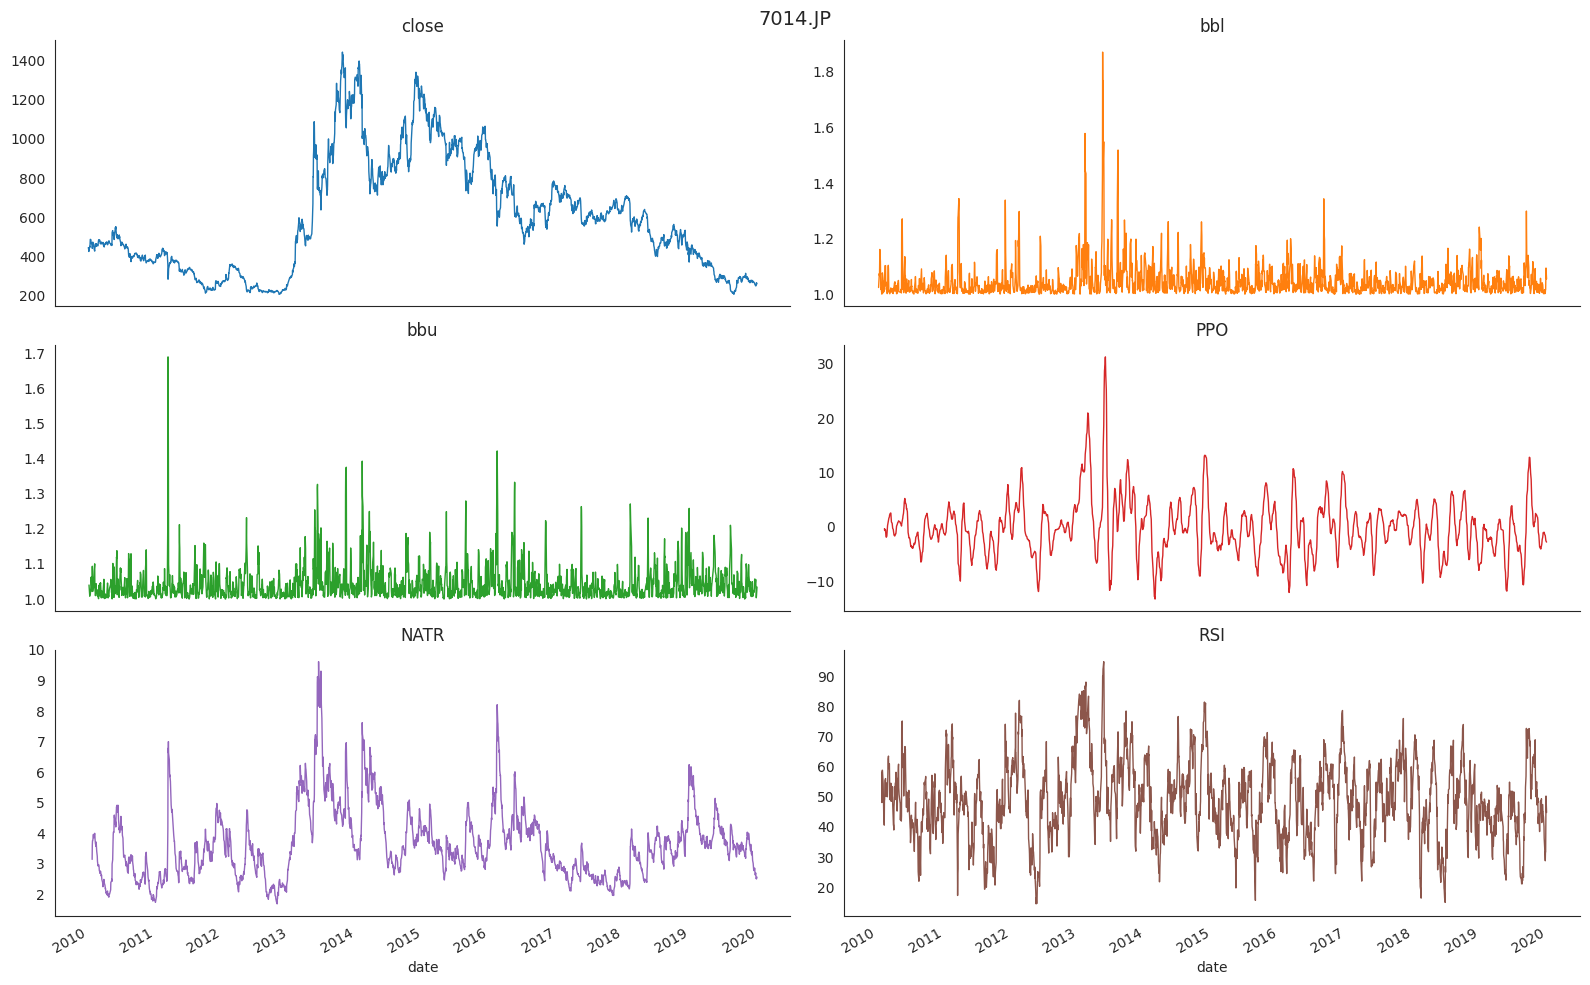

In [30]:
indicators = ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']
ticker = np.random.choice(data.index.get_level_values('ticker'))
(data.loc[idx[ticker, :], indicators].reset_index('ticker', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)

In [31]:
data = data.drop(prices.columns, axis=1)

### Create time period indicators

In [32]:
dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

## Compute forward returns

In [33]:
outcomes = []
by_ticker = data.groupby('ticker')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_ticker[f'ret_{t}'].shift(-t)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2311856 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('4212.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ret_1            float64
 1   ret_rel_perc_1   float64
 2   ret_5            float64
 3   ret_rel_perc_5   float64
 4   ret_10           float64
 5   ret_rel_perc_10  float64
 6   ret_21           float64
 7   ret_rel_perc_21  float64
 8   ret_63           float64
 9   ret_rel_perc_63  float64
 10  PPO              float64
 11  NATR             float64
 12  RSI              float64
 13  bbl              float64
 14  bbu              float64
 15  weekday          int32  
 16  month            int32  
 17  year             int32  
 18  fwd_ret_01       float64
 19  fwd_ret_05       float64
 20  fwd_ret_10       float64
 21  fwd_ret_21       float64
 22  fwd_ret_63       float64
dtypes: float64(20), int32(3)
memory usage: 452.8+ MB


In [35]:
data.to_hdf('data.h5', 'stooq/japan/equities')